<a href="https://colab.research.google.com/github/yastiaisyah/DataSynthesis/blob/main/13_10_23_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


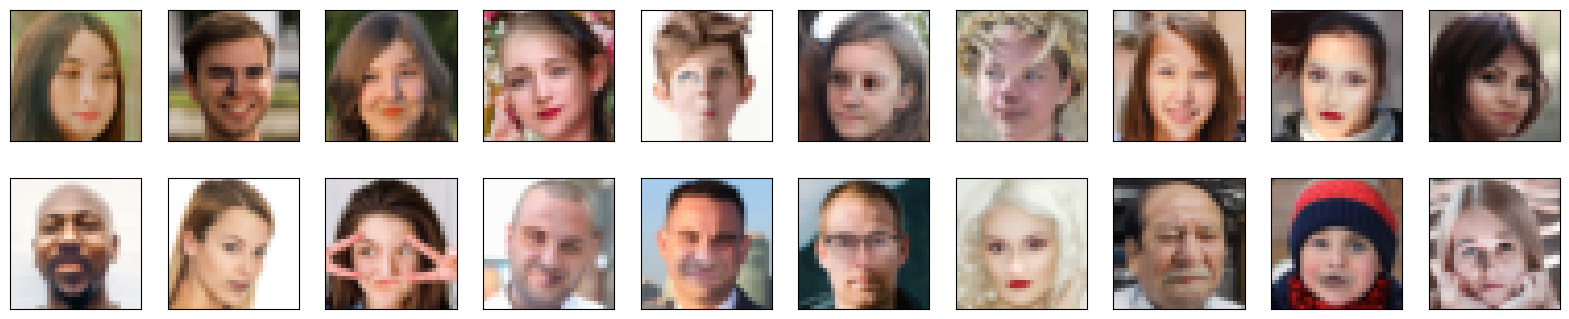

In [2]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Colab Notebooks/dataset/real_and_fake_face/training_real/'


import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

def get_dataloader(batch_size, image_size, data_dir= r'/content/drive/MyDrive/dataset/real_and_fake_face/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """

    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),transforms.CenterCrop(image_size),transforms.ToTensor()])

    train_data = datasets.ImageFolder(data_dir,transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=False)
    return train_loader

# Define function hyperparameters
batch_size = 32
img_size = 32


# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = next(dataiter)  # Use next() to get the next batch

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size // 2, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])

In [3]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1.
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min , max=feature_range
    x = x*(max-min)+min
    return x


# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(0.7333)


In [4]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):


    layers = []
    conv_layer = nn.Conv2d(in_channels = in_channels,out_channels = out_channels,
                          kernel_size = kernel_size,stride = stride,padding = padding , bias=False)
    layers.append(conv_layer)
    if (batch_norm):
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

class Discriminator(nn.Module):
    def __init__(self, conv_dim):
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4)
        self.conv4 = conv(conv_dim * 4, conv_dim * 8, 4)
        self.fc = nn.Linear(conv_dim * 8 * 2 * 2, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = x.view(-1, self.conv_dim * 8 * 2 * 2)
        x = self.fc(x)
        x = self.dropout(x)
        x = F.sigmoid(x)  # Apply sigmoid activation
        return x

# This is the recommended change to add the sigmoid activation.


def deconv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):

    layers=[]

    deconv_layer=nn.ConvTranspose2d(in_channels=in_channels,out_channels=out_channels,
                             kernel_size=kernel_size,stride=stride,padding=padding,bias=False)
    layers.append(deconv_layer)

    if (batch_norm):
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)


class Generator(nn.Module):
    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()
        self.conv_dim = conv_dim

        # Define the layers
        self.fc = nn.Linear(z_size, conv_dim * 8 * 2 * 2)
        self.deconv1 = deconv(conv_dim * 8, conv_dim * 4, 4)
        self.deconv2 = deconv(conv_dim * 4, conv_dim * 2, 4)
        self.deconv3 = deconv(conv_dim * 2, conv_dim, 4)
        self.deconv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.fc(x)
        x = self.dropout(x)
        x = x.view(-1, self.conv_dim * 8, 2, 2)
        x = F.relu(self.deconv1(x))
        x = self.dropout(x)
        x = F.relu(self.deconv2(x))
        x = self.dropout(x)
        x = F.relu(self.deconv3(x))
        x = self.dropout(x)
        x = torch.tanh(self.deconv4(x))  # Apply tanh activation
        return x


def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__

    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.02)

        # The bias terms, if they exist, set to 0
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_()


def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)

    return D, G

# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100


D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 

In [5]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [6]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)*0.9
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss


import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = torch.optim.Adam(D.parameters(),lr=0.0005, betas=(0.1, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(),lr=0.0005,betas=(0.1,0.999))


def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''

    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================

            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
            D_out = D(real_images)
            d_real_loss = real_loss(D_out)

            z = np.random.uniform(-1,1,size=(batch_size,z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_out = D(fake_images)
            d_fake_loss = fake_loss(D_out)

            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            z = np.random.uniform(-1,1,size=(batch_size,z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_out = D(fake_images)
            g_loss = real_loss(D_out)

            g_loss.backward()
            g_optimizer.step()

            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    # finally return losses
    return losses

# set number of epochs
n_epochs = 15

# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   15] | d_loss: 1.4592 | g_loss: 0.6056
Epoch [    1/   15] | d_loss: 1.3427 | g_loss: 0.6084
Epoch [    2/   15] | d_loss: 1.3543 | g_loss: 0.5980
Epoch [    2/   15] | d_loss: 1.3369 | g_loss: 0.6027
Epoch [    3/   15] | d_loss: 1.2955 | g_loss: 0.6033
Epoch [    3/   15] | d_loss: 1.2884 | g_loss: 0.6033
Epoch [    4/   15] | d_loss: 1.3268 | g_loss: 0.6033
Epoch [    4/   15] | d_loss: 1.2741 | g_loss: 0.6192
Epoch [    5/   15] | d_loss: 1.2794 | g_loss: 0.6033
Epoch [    5/   15] | d_loss: 1.3374 | g_loss: 0.5822
Epoch [    6/   15] | d_loss: 1.2917 | g_loss: 0.6138
Epoch [    6/   15] | d_loss: 1.3145 | g_loss: 0.6245
Epoch [    7/   15] | d_loss: 1.3443 | g_loss: 0.5980
Epoch [    7/   15] | d_loss: 1.2568 | g_loss: 0.6192
Epoch [    8/   15] | d_loss: 1.3252 | g_loss: 0.5822
Epoch [    8/   15] | d_loss: 1.2759 | g_loss: 0.5875
Epoch [    9/   15] | d_loss: 1.3129 | g_loss: 0.6350
Epoch [    9/   15] | d_loss: 1.2723 | g_loss: 0.6033
Epoch [   10/   15] | d_loss

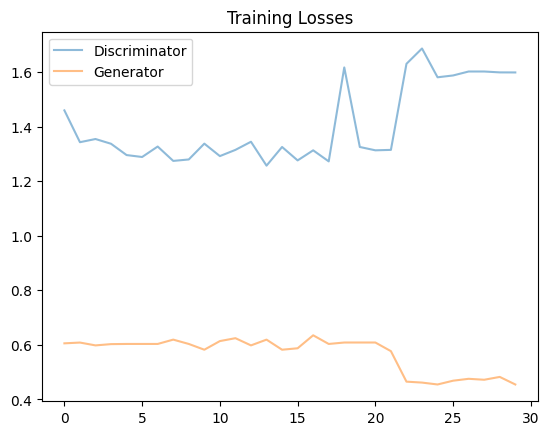

In [7]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

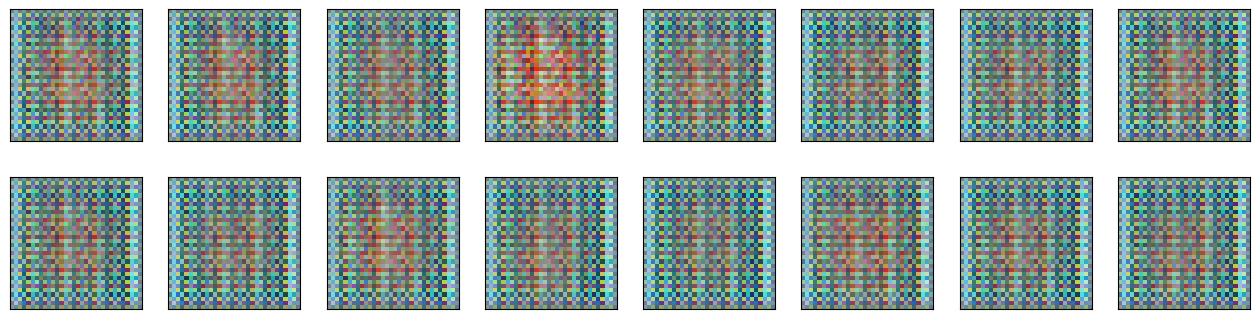

In [8]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples(-1, samples)